In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Charger les données
df_earthquake = pd.read_csv("earthquakes.csv")

In [17]:
# Prétraitement des données
df = df_earthquake.drop(['postcode', 'subnational', 'continent', 'city'], axis=1)
df_numeric_columns = df.select_dtypes(include=['number'])
df_numeric = df[df_numeric_columns.columns]

def winsorized_column(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in df_numeric.columns:
    df_numeric[col] = winsorized_column(df_numeric[col])

C:\Users\hp\AppData\Local\Temp\ipykernel_16716\3351143320.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[col] = winsorized_column(df_numeric[col])
C:\Users\hp\AppData\Local\Temp\ipykernel_16716\3351143320.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[col] = winsorized_column(df_numeric[col])
C:\Users\hp\AppData\Local\Temp\ipykernel_16716\3351143320.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

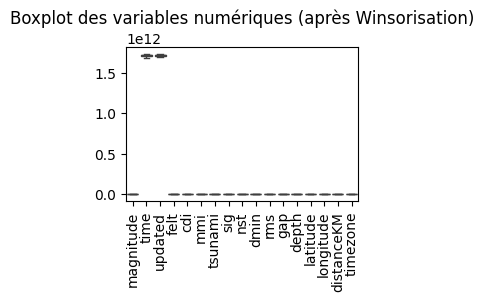

In [21]:
# Analyse exploratoire : Boxplot pour visualiser les outliers
plt.figure(figsize=(3, 2))
sns.boxplot(data=df_numeric)
plt.title("Boxplot des variables numériques (après Winsorisation)")
plt.xticks(rotation=90)
plt.show()

In [22]:
# Séparer les features et la target
X = df_numeric[['timezone', 'longitude', 'latitude', 'depth', 'rms', 'cdi',
                'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'time', 'updated']]
Y = df_numeric['magnitude']

In [23]:
# Diviser les données en train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [24]:
# Initialiser les modèles
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
lin_reg = LinearRegression()
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [26]:
# Entraîner les modèles
rf_regressor.fit(X_train, Y_train)
lin_reg.fit(X_train, Y_train)
gbr.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [35]:
# Prédictions
rf_train_pred = rf_regressor.predict(X_train)
rf_test_pred = rf_regressor.predict(X_test)

lin_train_pred = lin_reg.predict(X_train)
lin_test_pred = lin_reg.predict(X_test)

gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

In [29]:
# Fonctions d'évaluation
def map_score(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mape = map_score(true, predicted)
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, mape, r2_square

In [30]:
# Évaluer les performances
models = ['Random Forest', 'Linear Regression', 'Gradient Boosting']
train_results = [
    evaluate(Y_train, rf_train_pred),
    evaluate(Y_train, lin_train_pred),
    evaluate(Y_train, gbr_train_pred)
]
test_results = [
    evaluate(Y_test, rf_test_pred),
    evaluate(Y_test, lin_test_pred),
    evaluate(Y_test, gbr_test_pred)
]

In [31]:
# Résumé des performances
performance_df = pd.DataFrame(
    {
        'Model': models,
        'Train_R2': [r[4] for r in train_results],
        'Test_R2': [r[4] for r in test_results],
        'Train_RMSE': [r[2] for r in train_results],
        'Test_RMSE': [r[2] for r in test_results]
    }
)
print(performance_df)

               Model  Train_R2   Test_R2  Train_RMSE  Test_RMSE
0      Random Forest  0.996881  0.992233    0.058574   0.091549
1  Linear Regression  0.886478  0.910626    0.353381   0.310559
2  Gradient Boosting  0.993232  0.989758    0.086283   0.105129


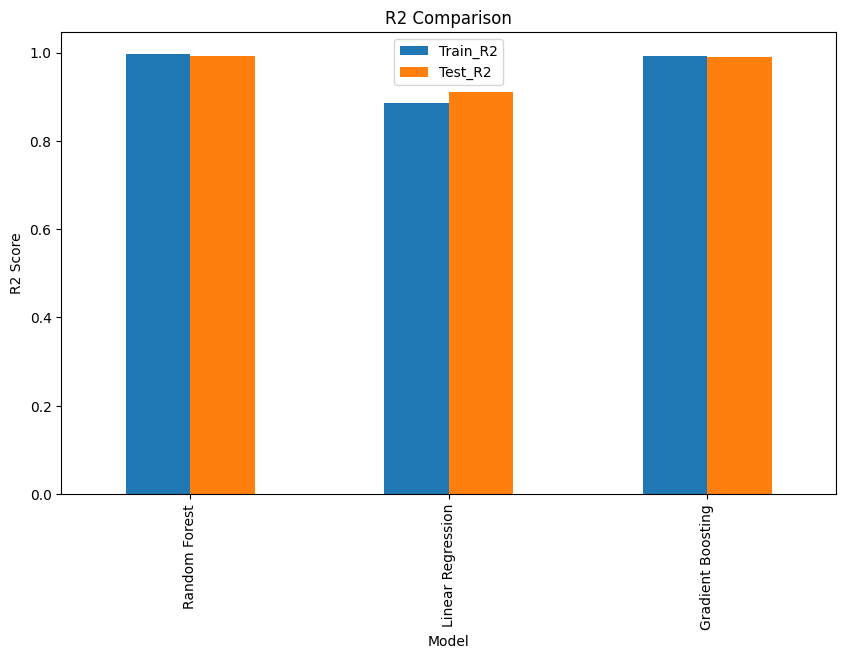

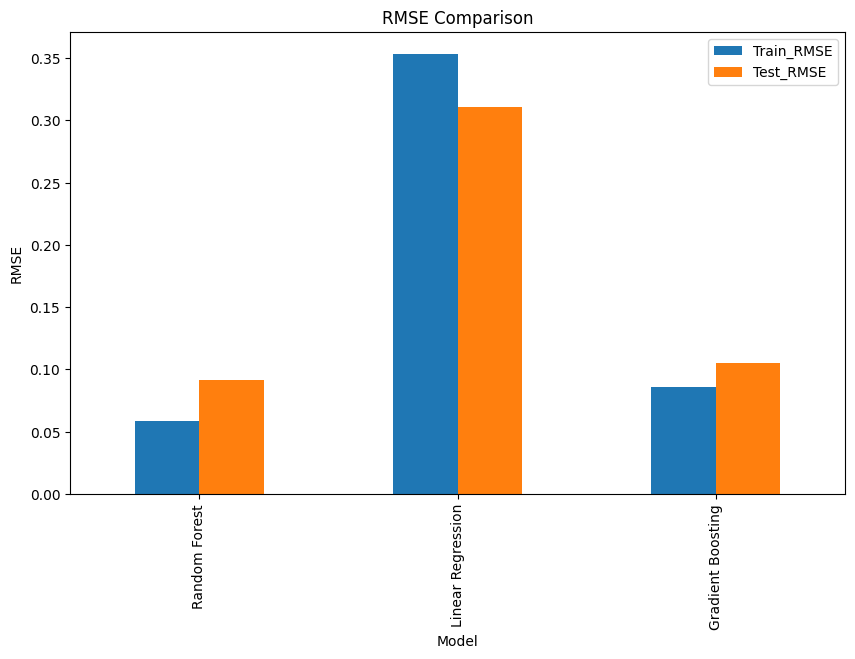

In [32]:
# Graphiques de comparaison
performance_df.set_index('Model', inplace=True)
performance_df[['Train_R2', 'Test_R2']].plot(kind='bar', figsize=(10, 6), title='R2 Comparison')
plt.ylabel('R2 Score')
plt.show()

performance_df[['Train_RMSE', 'Test_RMSE']].plot(kind='bar', figsize=(10, 6), title='RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

In [34]:
# Validation croisée
def cross_val(model):
    pred = cross_val_score(model, X_train, Y_train, cv=10)
    return pred.mean()

rf_cv_score = cross_val(rf_regressor)
lin_cv_score = cross_val(lin_reg)
gbr_cv_score = cross_val(gbr)

print(f"Random Forest CV Score: {rf_cv_score}")
print(f"Linear Regression CV Score: {lin_cv_score}")
print(f"Gradient Boosting CV Score: {gbr_cv_score}")

Random Forest CV Score: 0.9759019574619148
Linear Regression CV Score: 0.8817331372969
Gradient Boosting CV Score: 0.9698484441526233
